### Importamos las librerías necesarias

In [ ]:
import numpy as np
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Input, Flatten, Activation, Dropout, BatchNormalization, ReLU, Add, Concatenate
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomTranslation, RandomContrast
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

### Configuramos la gpu

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

### Carga de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install gdown
!gdown 'https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'
!unzip -q '/content/TP1-3-natural-scenes.zip'

Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=b028512f-18c0-4e93-8976-6772e09abdd3
To: /content/TP1-3-natural-scenes.zip
100% 363M/363M [00:09<00:00, 36.5MB/s]


In [ ]:
import zipfile
import os

# Ruta al archivo ZIP descargado (asegúrate de que esta ruta sea correcta)
zip_path = '/content/TP1-3-natural-scenes.zip'

# Extraer el contenido del ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/TP1-3-natural-scenes')

# Verifica si se ha extraído correctamente
os.listdir('/content/TP1-3-natural-scenes')

['seg_train', 'seg_test', 'seg_pred']

In [ ]:
# Directorio de los datos
DATA_DIRECTORY_TRAIN = Path("TP1-3-natural-scenes/seg_train/seg_train")
DATA_DIRECTORY_TEST = Path("TP1-3-natural-scenes/seg_test/seg_test")

# Tamaño del lote (batch size)
BATCH_SIZE = 64

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TRAIN,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TEST,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## Análisis exploratorio

#### Inspeccionamos las clases

In [ ]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


#### Observamos si el datset está balanceado

In [ ]:
# Directorio de las imágenes de entrenamiento
TRAIN_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/seg_train/seg_train")

# Diccionario para almacenar el conteo por clase
class_counts = {}

# Recorrer las carpetas dentro del directorio
for class_folder in TRAIN_IMAGES_DIRECTORY.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name
        num_images = len(list(class_folder.glob("*.jpg")))  # Contar las imágenes en la carpeta
        class_counts[class_name] = num_images

# Mostrar el conteo por clase
for class_name, count in class_counts.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")


Clase: buildings, Número de imágenes: 2191
Clase: glacier, Número de imágenes: 2404
Clase: sea, Número de imágenes: 2274
Clase: forest, Número de imágenes: 2271
Clase: street, Número de imágenes: 2382
Clase: mountain, Número de imágenes: 2512


Podemos observar que tenemos las imágenes distribuidas en 6 clases, que, si bien no tienen exactamente la misma cantidad de imágenes por clases, la diferencia es muy pequeña, por lo que podemos decir que nuestro dataset está balanceado.

#### Visualizamos algunas imágenes de ejemplo

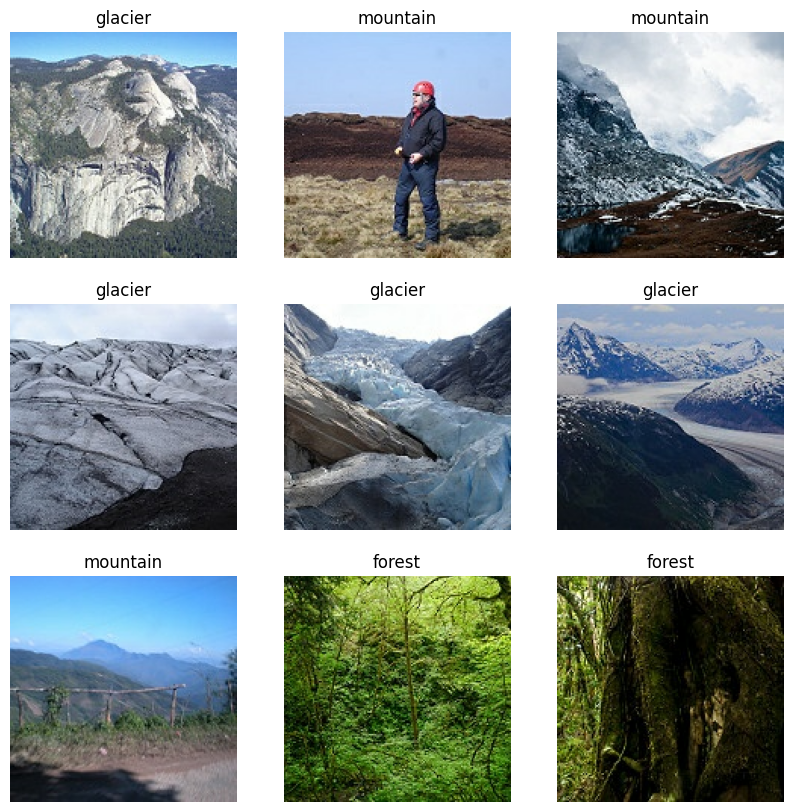

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

### División de los datos en X y en Y

In [ ]:
# Función para dividir características (X) y etiquetas (y)
def split_features_labels(image, label):
    return image, label

# Dividiendo en X (imágenes) e y (etiquetas)
X_train, y_train = zip(*train_ds)
X_test, y_test = zip(*val_ds)

# Modelo con capas densas

### Definimos nuestro modelo utilizando Tensorflow

In [ ]:
model_dense = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Rescaling(1./255),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(6, activation="softmax"),
])

### Resumen del modelo

In [ ]:
model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 rescaling (Rescaling)       (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 8652934 (33.01 MB)
Trainable params: 86529

### Entrenamos el modelo

In [ ]:
# Compilación del modelo
model_dense.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model_dense.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
220/220 [==============================] - 9s 38ms/step - loss: 2.1046 - accuracy: 0.4026 - val_loss: 1.4627 - val_accuracy: 0.4790
Epoch 2/10
220/220 [==============================] - 7s 34ms/step - loss: 1.4085 - accuracy: 0.4769 - val_loss: 1.5767 - val_accuracy: 0.3867
Epoch 3/10
220/220 [==============================] - 8s 34ms/step - loss: 1.2849 - accuracy: 0.5194 - val_loss: 1.4789 - val_accuracy: 0.4567
Epoch 4/10
220/220 [==============================] - 7s 34ms/step - loss: 1.2083 - accuracy: 0.5460 - val_loss: 1.2531 - val_accuracy: 0.5223
Epoch 5/10
220/220 [==============================] - 7s 33ms/step - loss: 1.1950 - accuracy: 0.5502 - val_loss: 1.4114 - val_accuracy: 0.4617
Epoch 6/10
220/220 [==============================] - 7s 34ms/step - loss: 1.1685 - accuracy: 0.5623 - val_loss: 1.2780 - val_accuracy: 0.5147
Epoch 7/10
220/220 [==============================] - 7s 32ms/step - loss: 1.1114 - accuracy: 0.5873 - val_loss: 1.2567 - val_accuracy: 0.5270

### Evaluamos el modelo

In [ ]:
# Evaluación en el conjunto de entrenamiento
train_loss, train_acc = model_dense.evaluate(train_ds)
print(f"Precisión en el conjunto de entrenamiento: {train_acc:.4f}")

# Evaluación en el conjunto de prueba
test_loss, test_acc = model_dense.evaluate(val_ds)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")


220/220 [==============================] - 1s 6ms/step - loss: 0.9672 - accuracy: 0.6340
Precisión en el conjunto de entrenamiento: 0.6340
47/47 [==============================] - 0s 6ms/step - loss: 1.2331 - accuracy: 0.5467
Precisión en el conjunto de prueba: 0.5467


### Gráfico del historial de métricas

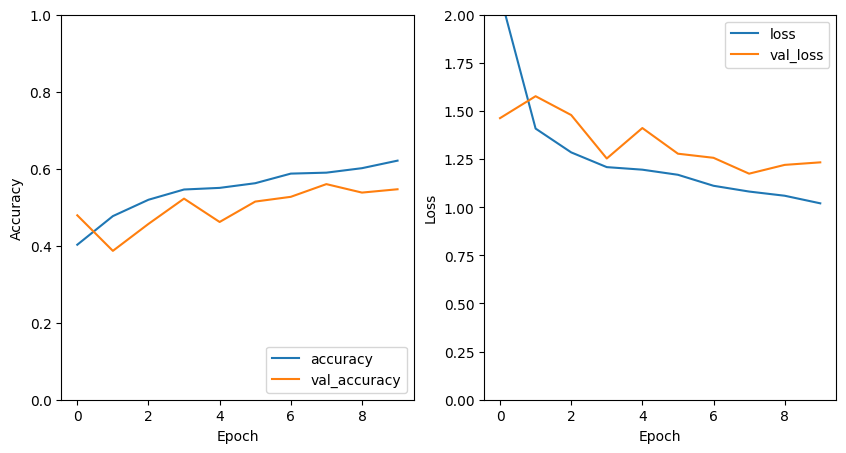

In [ ]:
# Plot the training history, accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

### Predecimos en nuevas imágenes

1/1 [==============================] - 0s 28ms/step


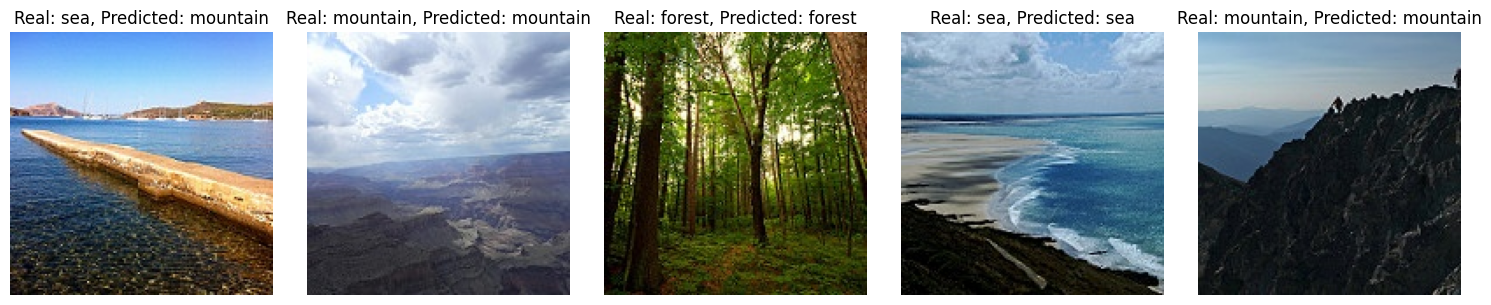

In [ ]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = model_dense.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()


# Modelo con capas convolucionales y densas.

### Definimos la arquitectura de la red

In [ ]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Normalizo las imágenes para que están en valores entro 0 y 1
    x = Rescaling(1./255)(i)

    # Data Aumentation
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

### Construimos el modelo

In [ ]:
print("Building model")
model_dense_cnn = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), 6)

model_dense_cnn.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


### Resumen del modelo

In [ ]:
model_dense_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_translation (Random  (None, 150, 150, 3)       0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 150, 150, 3)       0         
 trast)                                                      

### Entrenamos el modelo

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 10

# Entrena el modelo
history = model_dense_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
220/220 [==============================] - 54s 238ms/step - loss: 1.1596 - accuracy: 0.5333 - val_loss: 0.9349 - val_accuracy: 0.6460
Epoch 2/10
220/220 [==============================] - 51s 232ms/step - loss: 0.9322 - accuracy: 0.6423 - val_loss: 0.8840 - val_accuracy: 0.6507
Epoch 3/10
220/220 [==============================] - 51s 230ms/step - loss: 0.8077 - accuracy: 0.6906 - val_loss: 0.7666 - val_accuracy: 0.7177
Epoch 4/10
220/220 [==============================] - 50s 229ms/step - loss: 0.7451 - accuracy: 0.7193 - val_loss: 0.7405 - val_accuracy: 0.7277
Epoch 5/10
220/220 [==============================] - 50s 228ms/step - loss: 0.6949 - accuracy: 0.7390 - val_loss: 0.6447 - val_accuracy: 0.7710
Epoch 6/10
220/220 [==============================] - 49s 225ms/step - loss: 0.6683 - accuracy: 0.7546 - val_loss: 0.6600 - val_accuracy: 0.7497
Epoch 7/10
220/220 [==============================] - 49s 224ms/step - loss: 0.6377 - accuracy: 0.7628 - val_loss: 0.7149 - val_ac

### Evaluamos el modelo

In [ ]:
# Evaluación en el conjunto de entrenamiento
train_loss, train_acc = model_dense_cnn.evaluate(train_ds)
print(f"Precisión en el conjunto de entrenamiento: {train_acc:.4f}")

# Evaluación en el conjunto de prueba
test_loss, test_acc = model_dense_cnn.evaluate(val_ds)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")


220/220 [==============================] - 9s 40ms/step - loss: 0.5089 - accuracy: 0.8183
Precisión en el conjunto de entrenamiento: 0.8183
47/47 [==============================] - 2s 39ms/step - loss: 0.5463 - accuracy: 0.8063
Precisión en el conjunto de prueba: 0.8063


### Visualizamos resultados

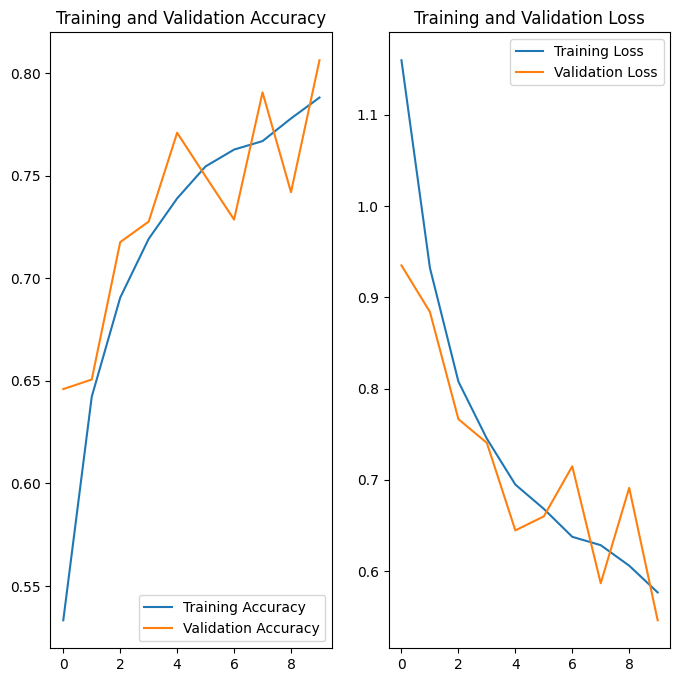

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predecimos en nuevas imágenes

1/1 [==============================] - 0s 28ms/step


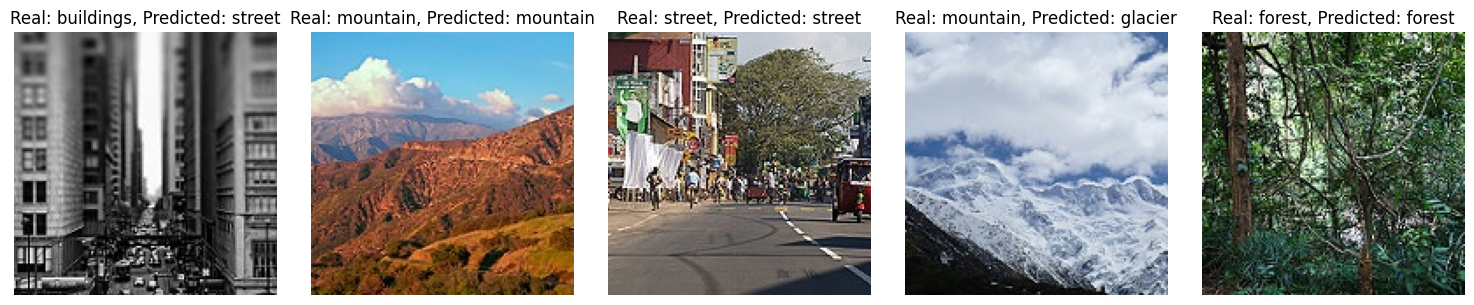

In [ ]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = model_dense_cnn.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

# Modelo que incluya bloques residuales identidad

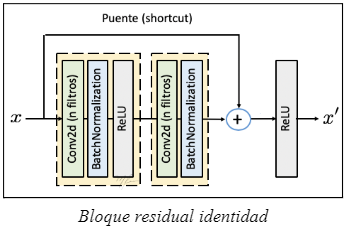


### Definimos nuestro bloque residual con la arquitectura planteada anteriormente

In [ ]:
def residual_block(x, filters):
    # Primera capa de convolución + BatchNormalization + ReLU

    shortcut = x  # Puente (shortcut)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Segunda capa de convolución + BatchNormalization
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Sumar el shortcut (conexión residual)
    x = Add()([x, shortcut])

    # Activación final
    x = ReLU()(x)

    return x

### Definimos una función para construie el modelo

In [ ]:
def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Rescaling(1./255)(inputs)

    x = Conv2D(32, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Bloques residuales
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    # Clasificación final
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Uso del modelo
input_shape = (150, 150, 3)
num_classes = 6
model_resnet = resnet(input_shape, num_classes)

### Resumen del modelo

In [ ]:
model_resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 75, 75, 32)           4736      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 75, 75, 32)           128       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_17 (ReLU)             (None, 75, 75, 32)           0         ['batch_normalization_18

### Entrenamos el modelo

In [ ]:
model_resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
220/220 [==============================] - 48s 211ms/step - loss: 5.6304 - accuracy: 0.5335 - val_loss: 1.0880 - val_accuracy: 0.5793
Epoch 2/10
220/220 [==============================] - 45s 204ms/step - loss: 0.9718 - accuracy: 0.6477 - val_loss: 1.6847 - val_accuracy: 0.5253
Epoch 3/10
220/220 [==============================] - 44s 200ms/step - loss: 0.8288 - accuracy: 0.7053 - val_loss: 0.8194 - val_accuracy: 0.7043
Epoch 4/10
220/220 [==============================] - 44s 198ms/step - loss: 0.6618 - accuracy: 0.7631 - val_loss: 1.0924 - val_accuracy: 0.6073
Epoch 5/10
220/220 [==============================] - 43s 195ms/step - loss: 0.5237 - accuracy: 0.8092 - val_loss: 1.3597 - val_accuracy: 0.5873
Epoch 6/10
220/220 [==============================] - 45s 202ms/step - loss: 0.4909 - accuracy: 0.8204 - val_loss: 1.4519 - val_accuracy: 0.5993
Epoch 7/10
220/220 [==============================] - 44s 201ms/step - loss: 0.4099 - accuracy: 0.8516 - val_loss: 1.5876 - val_ac

### Evaluamos el modelo

In [ ]:
# Evaluación en el conjunto de entrenamiento
train_loss, train_acc = model_resnet.evaluate(train_ds)
print(f"Precisión en el conjunto de entrenamiento: {train_acc:.4f}")

# Evaluación en el conjunto de prueba
test_loss, test_acc = model_resnet.evaluate(val_ds)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

220/220 [==============================] - 8s 38ms/step - loss: 0.6731 - accuracy: 0.7853
Precisión en el conjunto de entrenamiento: 0.7853
47/47 [==============================] - 2s 38ms/step - loss: 1.2342 - accuracy: 0.6763
Precisión en el conjunto de prueba: 0.6763


### Visualizamos los resultados

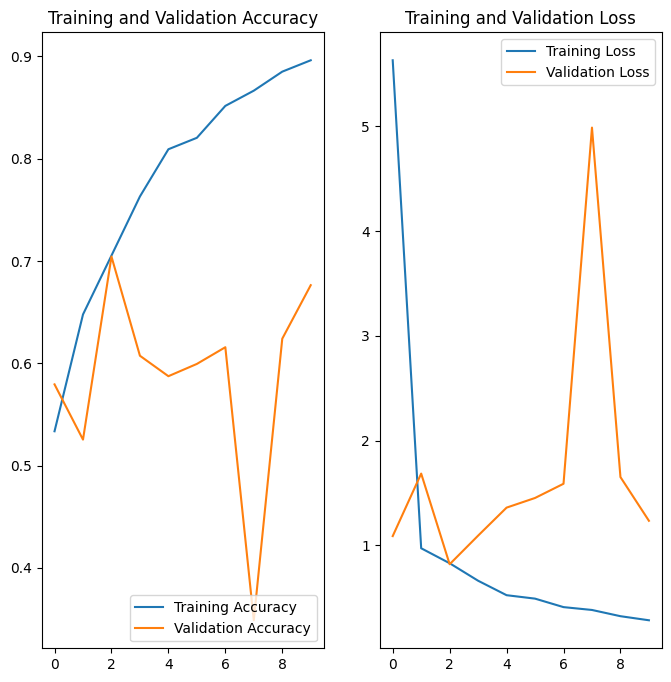

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predecimos en nuevas imágenes

1/1 [==============================] - 0s 27ms/step


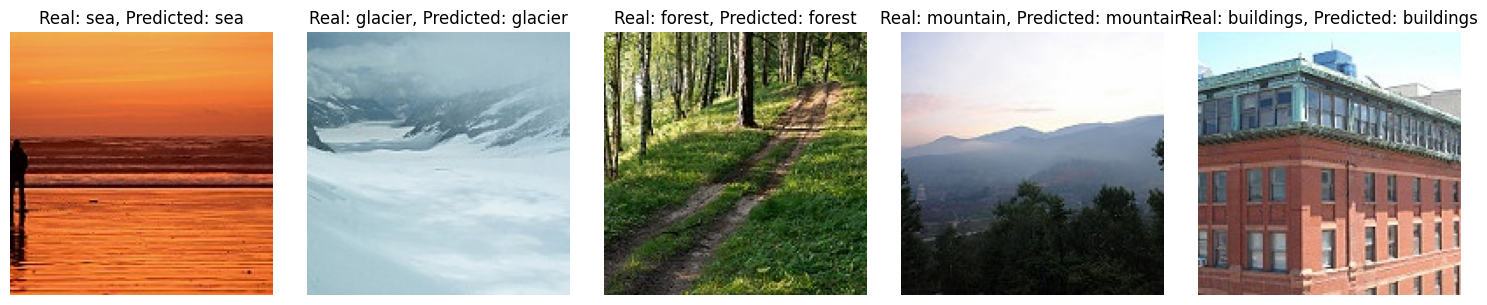

In [ ]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = model_resnet.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

# Modelo que utiliza Transfer Learning

### Definimos un bloque Inception

In [ ]:
# Definir el bloque Inception
def inception_module(x, filters):
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), activation='relu', padding='same')(x)
    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), activation='relu', padding='same')(x)
    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), activation='relu', padding='same')(x)
    maxpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    maxpool_conv = Conv2D(filters=filters[3], kernel_size=(1, 1), activation='relu', padding='same')(maxpool)
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    return output

### Definimos una función para construir el modelo con EfficientNetB0 como backbone

In [ ]:
# Construir el modelo con EfficientNetB0 como backbone
def inception_effnet(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Congelar las capas del backbone

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Añadir el módulo Inception
    x = inception_module(x, [64, 128, 32, 32])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Otro bloque Inception
    x = inception_module(x, [128, 192, 96, 64])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Clasificación
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

En este caso vamos a utilizar como backbone el modelo EfficientNetB0, ya que es un modelo muy eficiente en términos de presición, que funciona bastante rápido, y tiene una cantidad de parámetros y tamaño moderado.

A diferencia de ResNet o InceptionV3, que si bien tienen un poco más de presición, tienen una cantidad de parámetros mucho mayor y por lo tanto un tamaño mucho mayor, y una velocidad moderada. EfficientNetB0 optimiza la  relacion entre velocidad y presición siendo una opción muy buena para este caso.

### Creamos el modelo con sus respectivos parámetros

In [ ]:
# Parámetros del modelo
num_classes = 6
input_shape = (150, 150, 3)

model_tl = inception_effnet((150, 150, 3), 6)

16705208/16705208 [==============================] - 0s 0us/step


### Resumen del modelo

In [ ]:
model_tl.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 5, 5, 1280)           4049571   ['input_4[0][0]']             
 )                                                                                                
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 1280)           0         ['efficientnetb0[0][0]']      
 g2D)                                                                                             
                                                                                            

### Entrenamos el modelo

In [ ]:
# Compilar el modelo
model_tl.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
220/220 [==============================] - 105s 444ms/step - loss: 0.4112 - accuracy: 0.8802 - val_loss: 0.2452 - val_accuracy: 0.9160
Epoch 2/10
220/220 [==============================] - 96s 436ms/step - loss: 0.1825 - accuracy: 0.9388 - val_loss: 0.2915 - val_accuracy: 0.9113
Epoch 3/10
220/220 [==============================] - 96s 438ms/step - loss: 0.1360 - accuracy: 0.9553 - val_loss: 0.2837 - val_accuracy: 0.9220
Epoch 4/10
220/220 [==============================] - 97s 439ms/step - loss: 0.1097 - accuracy: 0.9659 - val_loss: 0.3863 - val_accuracy: 0.9143
Epoch 5/10
220/220 [==============================] - 97s 440ms/step - loss: 0.0800 - accuracy: 0.9744 - val_loss: 0.5140 - val_accuracy: 0.9130
Epoch 6/10
220/220 [==============================] - 96s 438ms/step - loss: 0.0534 - accuracy: 0.9823 - val_loss: 0.4463 - val_accuracy: 0.9207
Epoch 7/10
220/220 [==============================] - 96s 437ms/step - loss: 0.0451 - accuracy: 0.9863 - val_loss: 0.4880 - val_a

### Visualizamos resultados de entrenamiento:



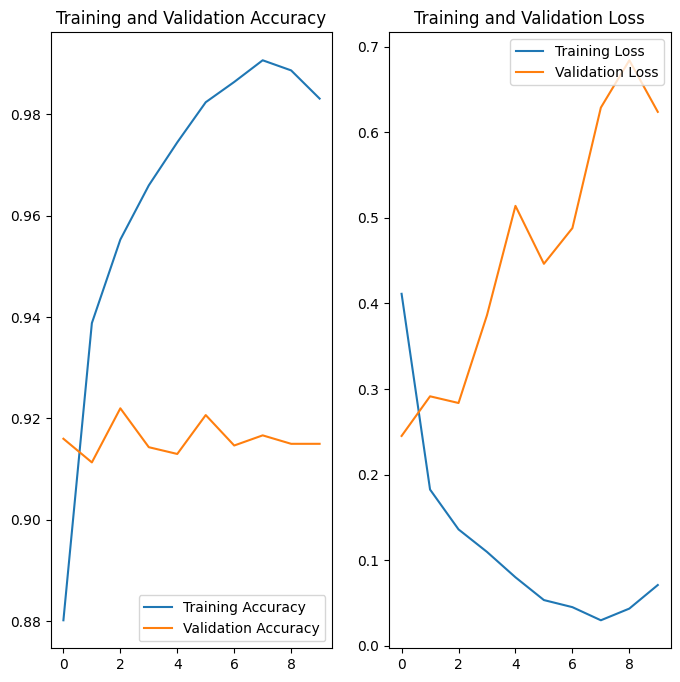

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predecimos en nuevas imagenes

1/1 [==============================] - 0s 55ms/step


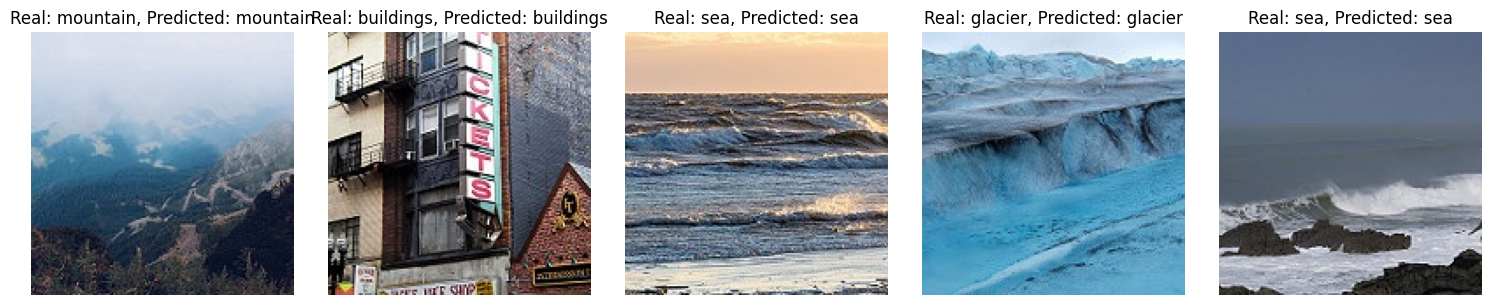

In [ ]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = model_tl.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

# Conclusiones:

| Modelo                  | Accuracy Train | Accuracy Test |
|-------------------------|----------------|---------------|
| Denso                   | 0.63           | 0.55         |
| Convolucional + Denso   | 0.79           | 0.80         |
| Bloques Residuales      | 0.90           | 0.68         |
| Transfer Learning       | 0.98           | 0.92         |

En esta tabla podemos comparar las presiciónes de cada uno de nuestros modelos, tanto para train como para validación.
Observamos que el modelo de Transfer Learning tiene el mejor rendimiento, con la mayor presición tanto para el conjunto de entrenamiento como para el de prueba. Lo que quiere decir que es el que mejor capacidad de predicción tiene.

Sin embargo, también es el que mayor consumo de cómputo requiere, ya que es el modelo con mayor complejidad en su arquitectura, y contiene capas preentrenadas.

Por otro lado, el modelo de bloques residuales, aunque no alcanza la presicion máxima del modelo de Transfer Learning, tiene un consumo de cómputo un poco menor, ya que utiliza menor cantidad de parámetros.

Concluyendo, si disponemos de los recursos computacionales necesarios, lo óptimo es usar el modelo de Transfer Learning, pero si no los tenemos, el modelo de bloques residuales ofrece una opción más balanceada, con un buen rendimiento, y menor demanda de recursos.
